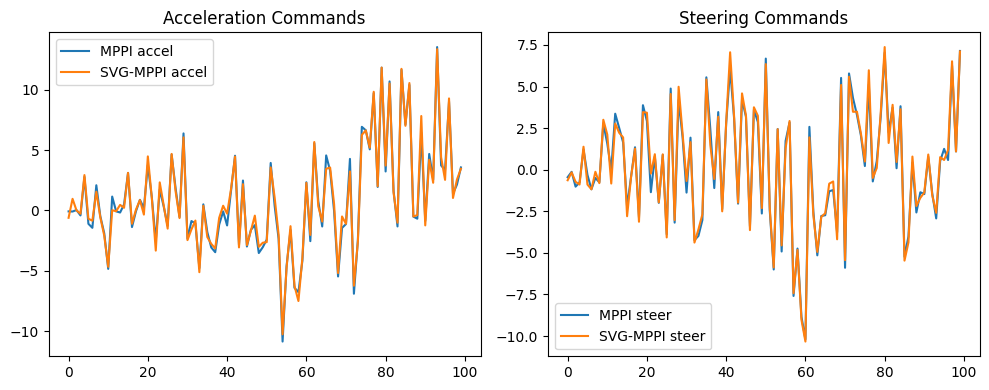

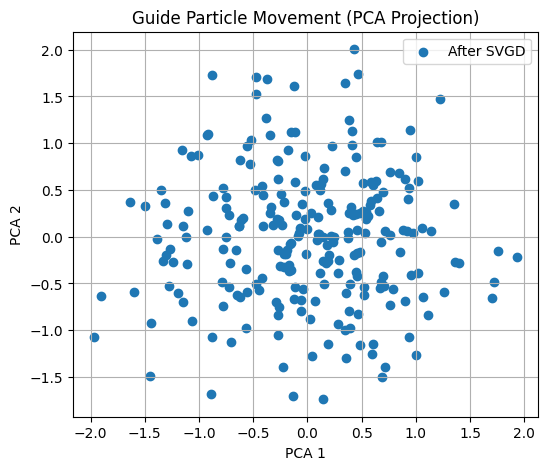

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

# Load trajectory
ref_traj = np.genfromtxt("levine.csv", delimiter=";", skip_header=3)
ref_xy_full = ref_traj[:, [1, 2]]
ref_v_full = ref_traj[:, 5]

# Parameters
T = 50
K = 256
M = 240
dim_u = 2
lambda_ = 1.0
dt = 0.1
Sigma = 0.2 * np.eye(dim_u)
np.random.seed(42)

# Cost weights
w_track = 1.0
w_control = 0.1

# Virtual obstacle
obstacle_center = np.array([ref_traj[30, 1], ref_traj[30, 2]])
obstacle_radius = 0.5

# Dynamics model
def dynamics_step(x, u):
    acc, steer = u
    x_, y_, theta, v = x
    L = 0.5
    v_new = v + acc * dt
    theta_new = theta + v * np.tan(steer) / L * dt
    x_new = x_ + v * np.cos(theta) * dt
    y_new = y_ + v * np.sin(theta) * dt
    return np.array([x_new, y_new, theta_new, v_new])

# Cost function with obstacle
def compute_cost_with_obstacle(traj, controls, ref_xy):
    tracking_error = np.linalg.norm(traj[:-1, :2] - ref_xy, axis=1)
    control_cost = np.linalg.norm(controls, axis=1)
    obs_dists = np.linalg.norm(traj[:-1, :2] - obstacle_center, axis=1)
    obstacle_cost = np.sum(obs_dists < obstacle_radius) * 10.0
    return np.sum(w_track * tracking_error + w_control * control_cost) + obstacle_cost

# Rollout simulation
def simulate_rollouts(x0, U_mean, Sigma, ref_xy, K):
    controls = np.random.multivariate_normal(
        U_mean.flatten(), np.kron(np.eye(T), Sigma), size=K
    ).reshape(K, T, dim_u)
    trajs = np.zeros((K, T + 1, 4))
    costs = np.zeros(K)
    for k in range(K):
        x = x0.copy()
        trajs[k, 0] = x
        for t in range(T):
            x = dynamics_step(x, controls[k, t])
            trajs[k, t + 1] = x
        costs[k] = compute_cost_with_obstacle(trajs[k], controls[k], ref_xy)
    return controls, trajs, costs

# SVGD transport
def svgd_transport(particles, costs):
    alpha = 0.1
    kernel_h = 1.0
    flat = particles.reshape(M, -1)
    K_mat = np.exp(-cdist(flat, flat, 'sqeuclidean') / kernel_h)
    grad_log_p = -(1 / lambda_) * (flat - flat[np.argmin(costs)])
    phi = (K_mat @ grad_log_p) / M + np.sum(np.gradient(K_mat, axis=1)[..., None], axis=1)
    return (flat + alpha * phi).reshape(M, T, dim_u)

# Initial state
x0 = np.array([ref_xy_full[0, 0], ref_xy_full[0, 1], 0.0, ref_v_full[0]])
U_nominal = np.zeros((T, dim_u))
mppi_controls = []
svgd_controls = []

# Rollout loop
for step in range(100):
    ref_xy = ref_xy_full[step:step + T]

    # --- MPPI ---
    controls_mppi, _, costs_mppi = simulate_rollouts(x0, U_nominal, Sigma, ref_xy, K)
    weights = np.exp(-costs_mppi / lambda_)
    weights /= np.sum(weights)
    U_mppi = np.sum(weights[:, None, None] * controls_mppi, axis=0)
    mppi_controls.append(U_mppi[0])
    x0 = dynamics_step(x0, U_mppi[0])
    U_nominal[:-1] = U_mppi[1:]
    U_nominal[-1] = U_mppi[-1]

    # --- SVG-MPPI ---
    guides = controls_mppi[:M]
    guides_svgd = svgd_transport(guides, costs_mppi[:M])
    best = guides_svgd[np.argmin(costs_mppi[:M])]
    Sigma_svgd = np.cov(guides_svgd.reshape(M, -1).T)
    controls_svgd = np.random.multivariate_normal(
        best.flatten(), Sigma_svgd, size=K
    ).reshape(K, T, dim_u)

    # Simulate SVGD rollouts
    trajs_svgd = np.zeros((K, T + 1, 4))
    costs_svgd = np.zeros(K)
    for k in range(K):
        x = np.copy(x0)
        trajs_svgd[k, 0] = x
        for t in range(T):
            x = dynamics_step(x, controls_svgd[k, t])
            trajs_svgd[k, t + 1] = x
        costs_svgd[k] = compute_cost_with_obstacle(trajs_svgd[k], controls_svgd[k], ref_xy)

    weights_svgd = np.exp(-costs_svgd / lambda_)
    weights_svgd /= np.sum(weights_svgd)
    U_svgd = np.sum(weights_svgd[:, None, None] * controls_svgd, axis=0)
    svgd_controls.append(U_svgd[0])
    x0 = dynamics_step(x0, U_svgd[0])
    U_nominal[:-1] = U_svgd[1:]
    U_nominal[-1] = U_svgd[-1]

# Plot commands
mppi_controls = np.array(mppi_controls)
svgd_controls = np.array(svgd_controls)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mppi_controls[:, 0], label='MPPI accel')
plt.plot(svgd_controls[:, 0], label='SVG-MPPI accel')
plt.title("Acceleration Commands")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mppi_controls[:, 1], label='MPPI steer')
plt.plot(svgd_controls[:, 1], label='SVG-MPPI steer')
plt.title("Steering Commands")
plt.legend()
plt.tight_layout()
plt.show()

# Plot PCA view of particle transport
before = guides.reshape(M, -1)
after = guides_svgd.reshape(M, -1)
pca = PCA(n_components=2)
proj = pca.fit_transform(np.vstack([before, after]))
plt.figure(figsize=(6, 5))
# plt.scatter(proj[:M, 0], proj[:M, 1], label='Before SVGD')
plt.scatter(proj[M:, 0], proj[M:, 1], label='After SVGD')
plt.title("Guide Particle Movement (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


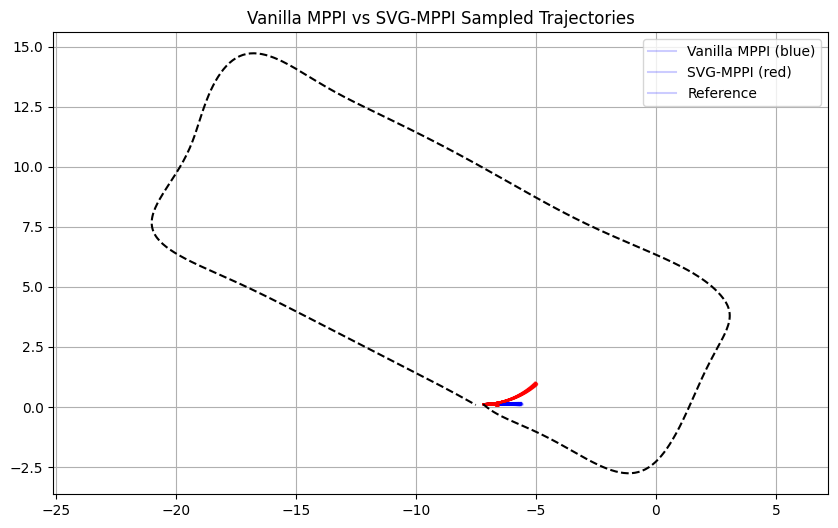

In [7]:
import pandas as pd
# Redefine df_clean to ensure it's available in this execution context
csv_path = "levine.csv"
df_clean = pd.read_csv(csv_path, comment='#', sep=';', header=None)
df_clean.columns = [
    's_m', 'x_m', 'y_m', 'psi_rad', 'kappa_radpm',
    'vx_mps', 'ax_mps2', 'delta_rad', 'extra_input'
]

# Now that df_clean is available, re-run the visualization code
import numpy as np
import matplotlib.pyplot as plt

# Extract x and y from the reference trajectory
ref_xy = df_clean[['x_m', 'y_m']].to_numpy()

# Define simulation parameters
K = 200  # number of trajectories
T = 30   # horizon length (timesteps)
dt = 0.1  # timestep duration

# Define a simple straight-line nominal control sequence for vanilla MPPI
u_nominal = np.tile(np.array([0.5, 0.0]), (T,))  # [v, steering] over time

# Simulate a basic kinematic model (x, y, theta) for each sample
def simulate_trajectory(initial_state, controls):
    x, y, theta = initial_state
    trajectory = []
    for t in range(0, len(controls), 2):
        v = controls[t]
        delta = controls[t + 1]
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += (v / 1.0) * np.tan(delta) * dt  # L=1.0 wheelbase
        trajectory.append((x, y))
    return np.array(trajectory)

# Generate vanilla MPPI samples (Gaussian around nominal)
vanilla_trajs = []
for _ in range(K):
    noise = np.random.normal(0, 0.1, T * 2)
    traj = simulate_trajectory(ref_xy[0].tolist() + [0.0], u_nominal + noise)
    vanilla_trajs.append(traj)

# Generate SVG-MPPI multimodal samples (split around two modes)
svgd_trajs = []
for _ in range(K // 2):
    noise = np.random.normal(0, 0.05, T * 2)
    mean1 = u_nominal + 0.3  # mode 1: slight right turn
    traj = simulate_trajectory(ref_xy[0].tolist() + [0.0], mean1 + noise)
    svgd_trajs.append(traj)

for _ in range(K // 2):
    noise = np.random.normal(0, 0.05, T * 2)
    mean2 = u_nominal - 0.3  # mode 2: slight left turn
    traj = simulate_trajectory(ref_xy[0].tolist() + [0.0], mean2 + noise)
    svgd_trajs.append(traj)

# Plotting
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.2)
for traj in svgd_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.2)

plt.plot(ref_xy[:, 0], ref_xy[:, 1], 'k--', label='Reference Trajectory')
plt.title('Vanilla MPPI vs SVG-MPPI Sampled Trajectories')
plt.legend(['Vanilla MPPI (blue)', 'SVG-MPPI (red)', 'Reference'])
plt.axis('equal')
plt.grid(True)
plt.show()


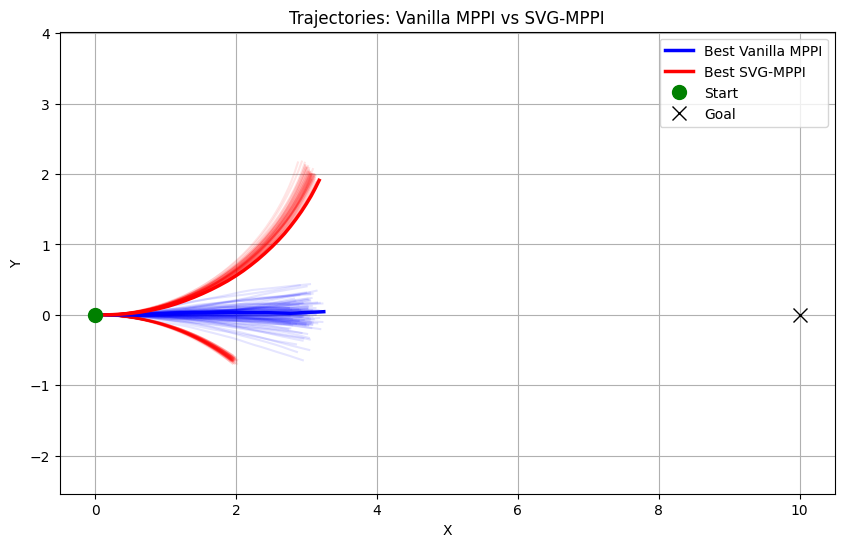

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define start and goal state (x, y, theta)
start_state = np.array([0.0, 0.0, 0.0])
goal_state = np.array([10.0, 0.0])

# Simulation parameters
K = 100  # number of samples
T = 30   # time steps
dt = 0.1

# Define cost function (L2 distance to goal at final time)
def compute_cost(traj):
    final_pos = traj[-1]
    return np.linalg.norm(final_pos - goal_state)

# Simulate trajectories
def simulate_trajectory(state, control_seq):
    x, y, theta = state
    traj = []
    for t in range(0, len(control_seq), 2):
        v = control_seq[t]
        delta = control_seq[t + 1]
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += (v / 1.0) * np.tan(delta) * dt
        traj.append([x, y])
    return np.array(traj)

# Nominal control (straight forward)
u_nominal = np.tile(np.array([1.0, 0.0]), T)

# Vanilla MPPI: Gaussian noise around nominal
vanilla_trajs = []
vanilla_costs = []
for _ in range(K):
    noise = np.random.normal(0, 0.2, T * 2)
    ctrl = u_nominal + noise
    traj = simulate_trajectory(start_state, ctrl)
    vanilla_trajs.append(traj)
    vanilla_costs.append(compute_cost(traj))

# SVG-MPPI: mode-seeking with 2 shifted means
svgd_trajs = []
svgd_costs = []

for _ in range(K // 2):
    ctrl = u_nominal + 0.3 + np.random.normal(0, 0.05, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs.append(traj)
    svgd_costs.append(compute_cost(traj))

for _ in range(K // 2):
    ctrl = u_nominal - 0.3 + np.random.normal(0, 0.05, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs.append(traj)
    svgd_costs.append(compute_cost(traj))

# Identify best cost trajectories
best_vanilla_idx = np.argmin(vanilla_costs)
best_svgd_idx = np.argmin(svgd_costs)

# Plot
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
for traj in svgd_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)

# Highlight best trajectories
plt.plot(vanilla_trajs[best_vanilla_idx][:, 0], vanilla_trajs[best_vanilla_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI')
plt.plot(svgd_trajs[best_svgd_idx][:, 0], svgd_trajs[best_svgd_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI')

# Start and Goal
plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state[0], goal_state[1], 'kx', markersize=10, label='Goal')

plt.title("Trajectories: Vanilla MPPI vs SVG-MPPI")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


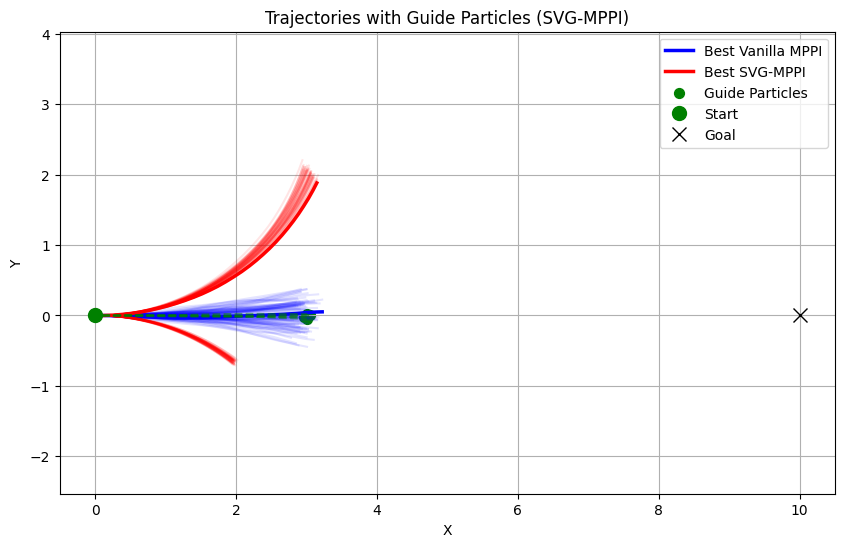

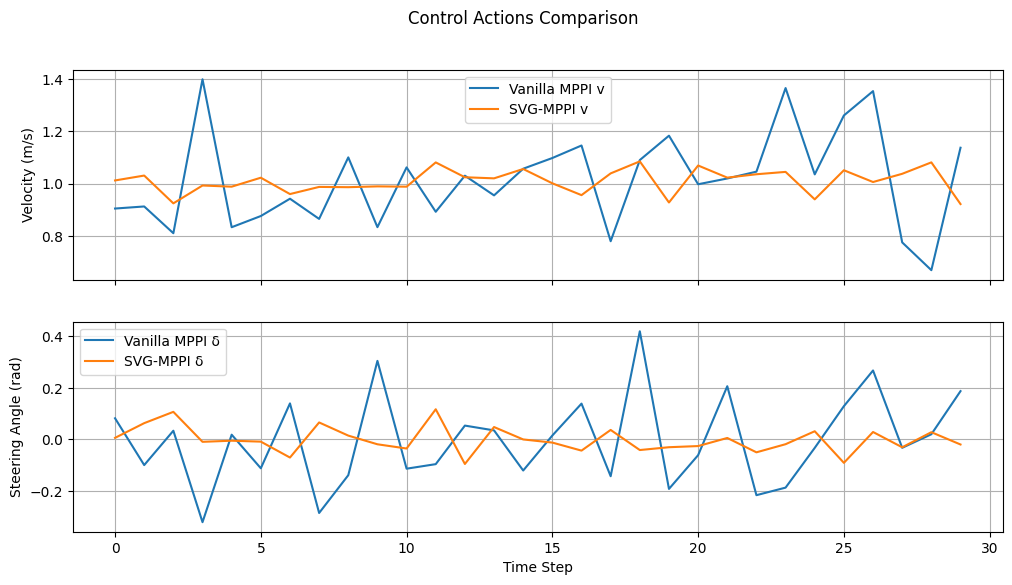

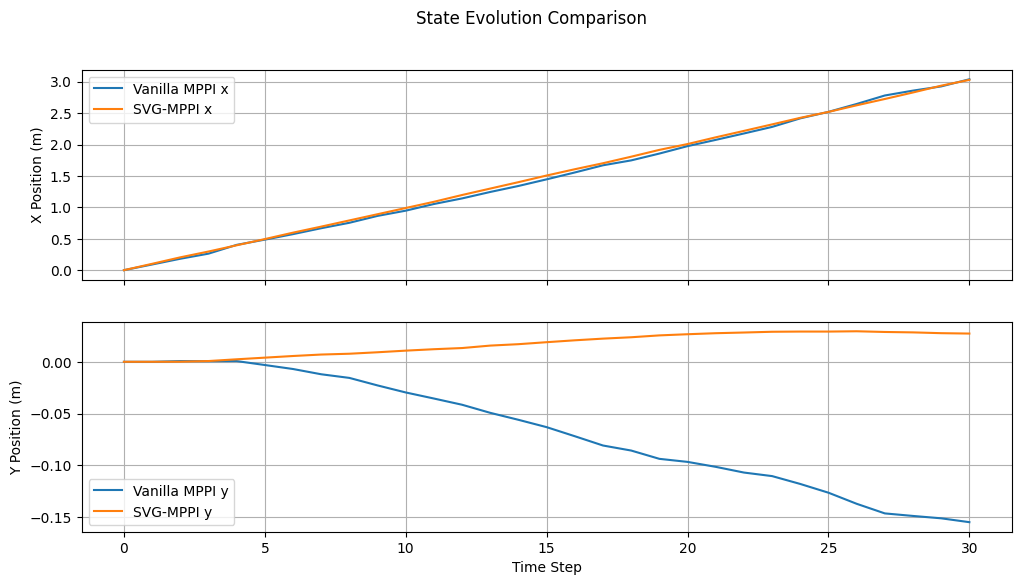

In [10]:
# Re-run simulation but include guide particles and compare state evolution + control sequences

# Regenerate guide particles for SVG-MPPI with no mode bias
guide_particles = []
guide_controls = []
guide_trajectories = []

for _ in range(5):  # small number of guide particles
    noise = np.random.normal(0, 0.05, T * 2)
    control = u_nominal + noise
    guide_controls.append(control)
    traj = simulate_trajectory(start_state, control)
    guide_particles.append(traj[-1])
    guide_trajectories.append(traj)

# Plot trajectories with guide particles
plt.figure(figsize=(10, 6))

# Vanilla
for traj in vanilla_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs[best_vanilla_idx][:, 0], vanilla_trajs[best_vanilla_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI')

# SVG-MPPI
for traj in svgd_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs[best_svgd_idx][:, 0], svgd_trajs[best_svgd_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI')

# Guide particles
for traj in guide_trajectories:
    plt.plot(traj[:, 0], traj[:, 1], color='green', linestyle='--', alpha=0.5)
plt.scatter([p[0] for p in guide_particles], [p[1] for p in guide_particles],
            color='green', s=50, label='Guide Particles')

plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state[0], goal_state[1], 'kx', markersize=10, label='Goal')
plt.title("Trajectories with Guide Particles (SVG-MPPI)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot control actions and state evolution
# -----------------------------

# Helper: extract controls and states
def get_controls_and_states(traj, ctrl_seq):
    states = [start_state[:2]]
    x, y, theta = start_state
    controls = []
    for t in range(0, len(ctrl_seq), 2):
        v = ctrl_seq[t]
        delta = ctrl_seq[t + 1]
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += (v / 1.0) * np.tan(delta) * dt
        states.append([x, y])
        controls.append([v, delta])
    return np.array(states), np.array(controls)

# Get best vanilla and SVG trajectories
vanilla_states, vanilla_controls = get_controls_and_states(
    vanilla_trajs[best_vanilla_idx], u_nominal + np.random.normal(0, 0.2, T * 2)
)
svgd_states, svgd_controls = get_controls_and_states(
    svgd_trajs[best_svgd_idx], u_nominal + np.random.normal(0, 0.05, T * 2)
)

# Plot comparison
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_controls[:, 0], label='Vanilla MPPI v')
axs[0].plot(svgd_controls[:, 0], label='SVG-MPPI v')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_controls[:, 1], label='Vanilla MPPI δ')
axs[1].plot(svgd_controls[:, 1], label='SVG-MPPI δ')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Steering Angle (rad)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Control Actions Comparison")
plt.show()

# Plot state evolution
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_states[:, 0], label='Vanilla MPPI x')
axs[0].plot(svgd_states[:, 0], label='SVG-MPPI x')
axs[0].set_ylabel("X Position (m)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_states[:, 1], label='Vanilla MPPI y')
axs[1].plot(svgd_states[:, 1], label='SVG-MPPI y')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Y Position (m)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("State Evolution Comparison")
plt.show()


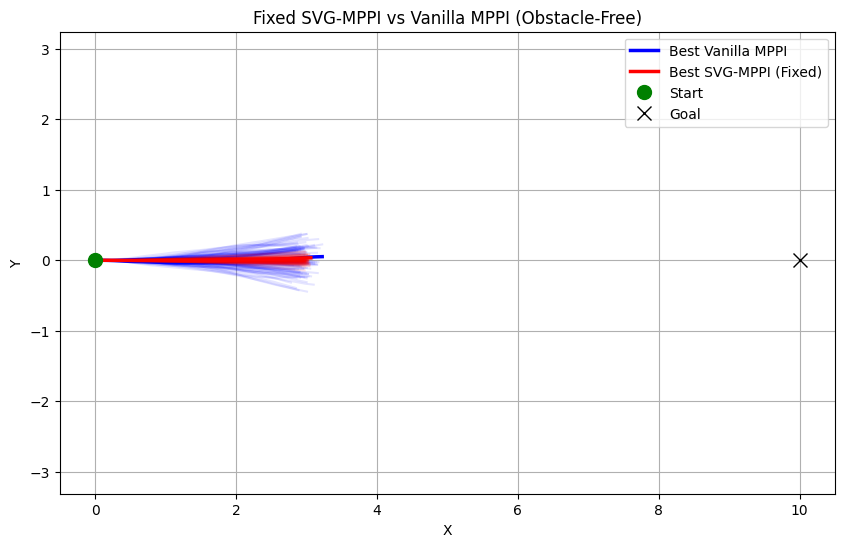

In [11]:
# Fix: Remove artificial mode bias in SVG-MPPI, so it behaves like vanilla MPPI in obstacle-free case

# Regenerate SVG-MPPI samples without directional bias (same mean as vanilla)
svgd_trajs_fixed = []
svgd_costs_fixed = []

for _ in range(K):
    ctrl = u_nominal + np.random.normal(0, 0.05, T * 2)  # same nominal, low variance
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs_fixed.append(traj)
    svgd_costs_fixed.append(compute_cost(traj))

# Identify best cost trajectory
best_svgd_fixed_idx = np.argmin(svgd_costs_fixed)

# Plot corrected trajectories
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs[best_vanilla_idx][:, 0], vanilla_trajs[best_vanilla_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI')

for traj in svgd_trajs_fixed:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs_fixed[best_svgd_fixed_idx][:, 0], svgd_trajs_fixed[best_svgd_fixed_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI (Fixed)')

plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state[0], goal_state[1], 'kx', markersize=10, label='Goal')
plt.title("Fixed SVG-MPPI vs Vanilla MPPI (Obstacle-Free)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


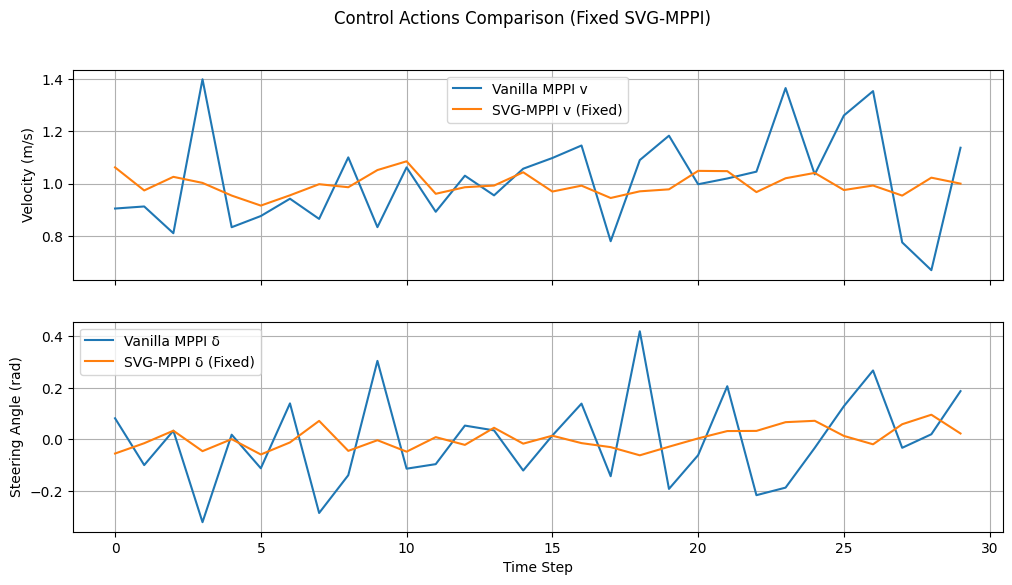

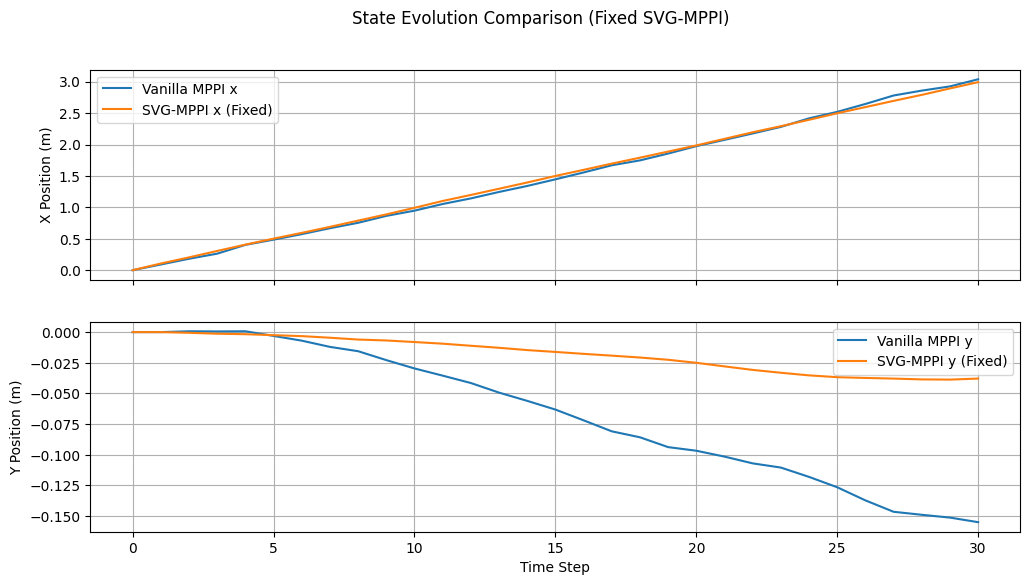

In [12]:
# Recalculate state evolution and control sequences for the fixed SVG-MPPI version

# Get best SVG-MPPI (fixed) trajectory and simulate states/controls
svgd_fixed_states, svgd_fixed_controls = get_controls_and_states(
    svgd_trajs_fixed[best_svgd_fixed_idx], u_nominal + np.random.normal(0, 0.05, T * 2)
)

# Plot control sequence comparison
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_controls[:, 0], label='Vanilla MPPI v')
axs[0].plot(svgd_fixed_controls[:, 0], label='SVG-MPPI v (Fixed)')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_controls[:, 1], label='Vanilla MPPI δ')
axs[1].plot(svgd_fixed_controls[:, 1], label='SVG-MPPI δ (Fixed)')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Steering Angle (rad)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Control Actions Comparison (Fixed SVG-MPPI)")
plt.show()

# Plot state evolution comparison
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_states[:, 0], label='Vanilla MPPI x')
axs[0].plot(svgd_fixed_states[:, 0], label='SVG-MPPI x (Fixed)')
axs[0].set_ylabel("X Position (m)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_states[:, 1], label='Vanilla MPPI y')
axs[1].plot(svgd_fixed_states[:, 1], label='SVG-MPPI y (Fixed)')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Y Position (m)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("State Evolution Comparison (Fixed SVG-MPPI)")
plt.show()


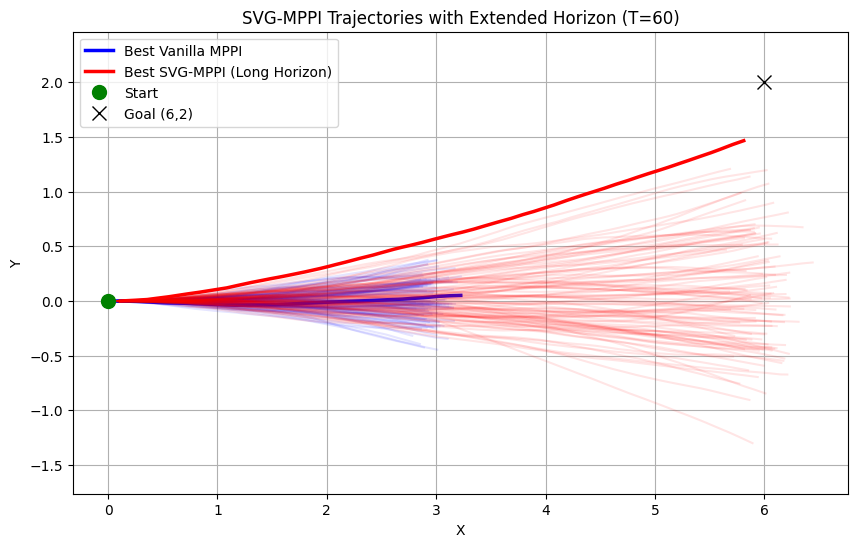

In [17]:
# Update goal state to (6.0, 2.0)
goal_state_turn = np.array([6.0, 2.0])

# Recompute SVG-MPPI samples for new goal
svgd_trajs_turn = []
svgd_costs_turn = []

# Increase prediction horizon
T_long = 60
u_nominal_long = np.tile(np.array([1.0, 0.0]), T_long)

# Recompute SVG-MPPI samples with longer horizon
svgd_trajs_long = []
svgd_costs_long = []

for _ in range(K):
    ctrl = u_nominal_long + np.random.normal(0, 0.2, T_long * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs_long.append(traj)
    svgd_costs_long.append(np.linalg.norm(traj[-1] - goal_state_turn))

best_svgd_long_idx = np.argmin(svgd_costs_long)

# Plot with extended horizon
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs[best_vanilla_idx][:, 0], vanilla_trajs[best_vanilla_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI')

for traj in svgd_trajs_long:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs_long[best_svgd_long_idx][:, 0], svgd_trajs_long[best_svgd_long_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI (Long Horizon)')

plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_turn[0], goal_state_turn[1], 'kx', markersize=10, label='Goal (6,2)')
plt.title("SVG-MPPI Trajectories with Extended Horizon (T=60)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


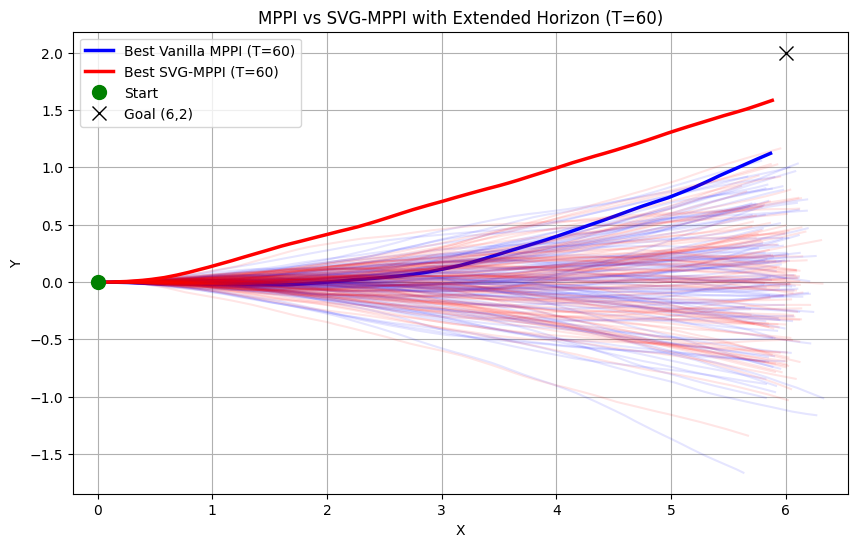

In [16]:
# Recompute both Vanilla MPPI and SVG-MPPI with extended horizon T = 60
T = 60
u_nominal = np.tile(np.array([1.0, 0.0]), T)

# Recalculate Vanilla MPPI trajectories
vanilla_trajs_long = []
vanilla_costs_long = []

for _ in range(K):
    noise = np.random.normal(0, 0.2, T * 2)
    ctrl = u_nominal + noise
    traj = simulate_trajectory(start_state, ctrl)
    vanilla_trajs_long.append(traj)
    vanilla_costs_long.append(np.linalg.norm(traj[-1] - goal_state_turn))

best_vanilla_long_idx = np.argmin(vanilla_costs_long)

# Recalculate SVG-MPPI trajectories (already done above)
svgd_trajs_long = []
svgd_costs_long = []

for _ in range(K):
    ctrl = u_nominal + np.random.normal(0, 0.2, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs_long.append(traj)
    svgd_costs_long.append(np.linalg.norm(traj[-1] - goal_state_turn))

best_svgd_long_idx = np.argmin(svgd_costs_long)

# Plot both with updated horizon
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs_long:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs_long[best_vanilla_long_idx][:, 0], vanilla_trajs_long[best_vanilla_long_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI (T=60)')

for traj in svgd_trajs_long:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs_long[best_svgd_long_idx][:, 0], svgd_trajs_long[best_svgd_long_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI (T=60)')

plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_turn[0], goal_state_turn[1], 'kx', markersize=10, label='Goal (6,2)')
plt.title("MPPI vs SVG-MPPI with Extended Horizon (T=60)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


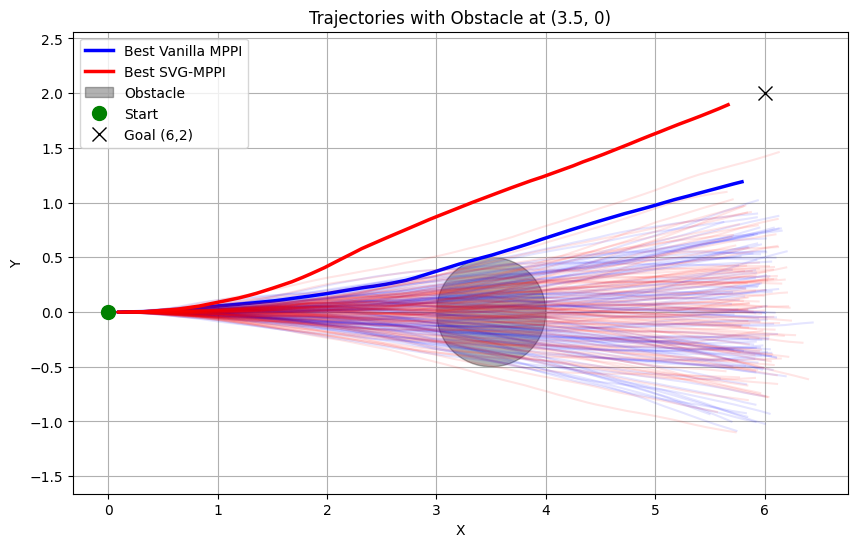

In [22]:
# Define obstacle: a circular obstacle at (3.5, 0) with radius 1.0
obstacle_center = np.array([3.5, 0.0])
obstacle_radius = 0.5

# Modified cost function: penalize proximity to obstacle + distance to goal
def compute_cost_with_obstacle(traj, goal):
    final_cost = np.linalg.norm(traj[-1] - goal)
    obstacle_cost = 0.0
    for pt in traj:
        dist = np.linalg.norm(pt - obstacle_center)
        if dist < obstacle_radius:
            obstacle_cost += 1000  # Large penalty inside obstacle
        else:
            obstacle_cost += 1.0 / dist  # Repulsion effect
    return final_cost + obstacle_cost

# Recompute trajectories for both methods with new cost function
vanilla_trajs_obs = []
vanilla_costs_obs = []
for _ in range(K):
    noise = np.random.normal(0, 0.2, T * 2)
    ctrl = u_nominal + noise
    traj = simulate_trajectory(start_state, ctrl)
    vanilla_trajs_obs.append(traj)
    vanilla_costs_obs.append(compute_cost_with_obstacle(traj, goal_state_turn))

best_vanilla_obs_idx = np.argmin(vanilla_costs_obs)

svgd_trajs_obs = []
svgd_costs_obs = []
for _ in range(K):
    ctrl = u_nominal + np.random.normal(0, 0.2, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs_obs.append(traj)
    svgd_costs_obs.append(compute_cost_with_obstacle(traj, goal_state_turn))

best_svgd_obs_idx = np.argmin(svgd_costs_obs)

# Plot with obstacle
plt.figure(figsize=(10, 6))
for traj in vanilla_trajs_obs:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs_obs[best_vanilla_obs_idx][:, 0], vanilla_trajs_obs[best_vanilla_obs_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI')

for traj in svgd_trajs_obs:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs_obs[best_svgd_obs_idx][:, 0], svgd_trajs_obs[best_svgd_obs_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI')

# Draw obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)

plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_turn[0], goal_state_turn[1], 'kx', markersize=10, label='Goal (6,2)')
plt.title("Trajectories with Obstacle at (3.5, 0)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


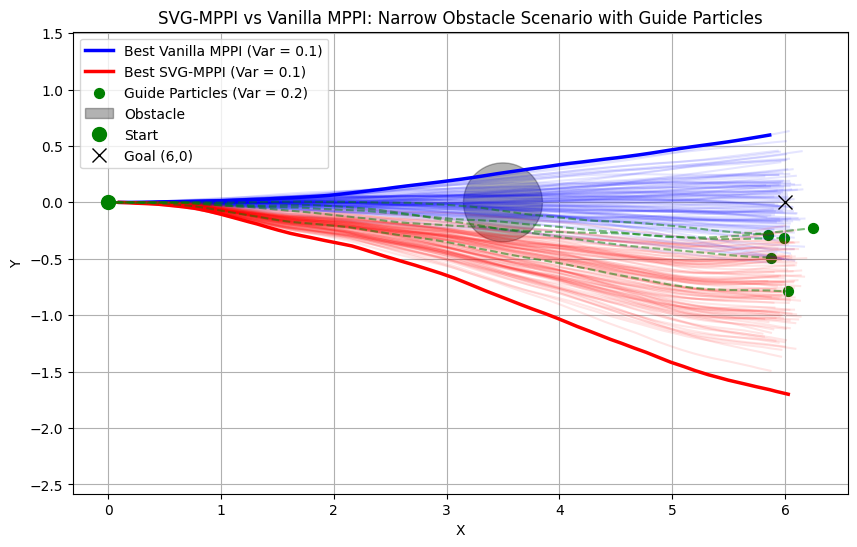

In [39]:
# Update the obstacle radius to make passage tighter and goal directly ahead
obstacle_radius = 0.35
goal_state_tight = np.array([6.0, 0.0])  # Straight ahead

# Cost function remains the same
def compute_cost_with_obstacle(traj, goal):
    final_cost = np.linalg.norm(traj[-1] - goal)
    obstacle_cost = 0.0
    for pt in traj:
        dist = np.linalg.norm(pt - obstacle_center)
        if dist < obstacle_radius:
            obstacle_cost += 1000  # Large penalty inside obstacle
        else:
            obstacle_cost += 1.0 / dist  # Repulsion
    return final_cost + obstacle_cost

# Recompute Vanilla MPPI with tighter scenario
vanilla_trajs_tight = []
vanilla_costs_tight = []

for _ in range(K):
    ctrl = u_nominal + np.random.normal(0, 0.1, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    vanilla_trajs_tight.append(traj)
    vanilla_costs_tight.append(compute_cost_with_obstacle(traj, goal_state_tight))

best_vanilla_tight_idx = np.argmin(vanilla_costs_tight)

# SVG-MPPI with guide particles
guide_controls = []
guide_trajectories = []
guide_endpoints = []

for _ in range(5):  # small number of guide particles
    ctrl = u_nominal + np.random.normal(0, 0.2, T * 2)
    guide_controls.append(ctrl)
    traj = simulate_trajectory(start_state, ctrl)
    guide_trajectories.append(traj)
    guide_endpoints.append(traj[-1])

svgd_trajs_tight = []
svgd_costs_tight = []

# Use guide particle closest to goal
guide_costs = [compute_cost_with_obstacle(traj, goal_state_tight) for traj in guide_trajectories]
best_guide_idx = np.argmin(guide_costs)
u_nominal_guide = guide_controls[best_guide_idx]

# Center SVG-MPPI sampling around best guide
for _ in range(K):
    ctrl = u_nominal_guide + np.random.normal(0, 0.1, T * 2)
    traj = simulate_trajectory(start_state, ctrl)
    svgd_trajs_tight.append(traj)
    svgd_costs_tight.append(compute_cost_with_obstacle(traj, goal_state_tight))

best_svgd_tight_idx = np.argmin(svgd_costs_tight)

# Plot
plt.figure(figsize=(10, 6))

# Vanilla trajectories
for traj in vanilla_trajs_tight:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
plt.plot(vanilla_trajs_tight[best_vanilla_tight_idx][:, 0],
         vanilla_trajs_tight[best_vanilla_tight_idx][:, 1],
         'b', linewidth=2.5, label='Best Vanilla MPPI (Var = 0.1)')

# SVG-MPPI trajectories
for traj in svgd_trajs_tight:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)
plt.plot(svgd_trajs_tight[best_svgd_tight_idx][:, 0],
         svgd_trajs_tight[best_svgd_tight_idx][:, 1],
         'r', linewidth=2.5, label='Best SVG-MPPI (Var = 0.1)')

# Guide particle trajectories
for traj in guide_trajectories:
    plt.plot(traj[:, 0], traj[:, 1], color='green', linestyle='--', alpha=0.5)
plt.scatter([p[0] for p in guide_endpoints], [p[1] for p in guide_endpoints],
            color='green', s=50, label='Guide Particles (Var = 0.2)')

# Obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)

# Start and goal
plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_tight[0], goal_state_tight[1], 'kx', markersize=10, label='Goal (6,0)')

plt.title("SVG-MPPI vs Vanilla MPPI: Narrow Obstacle Scenario with Guide Particles")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


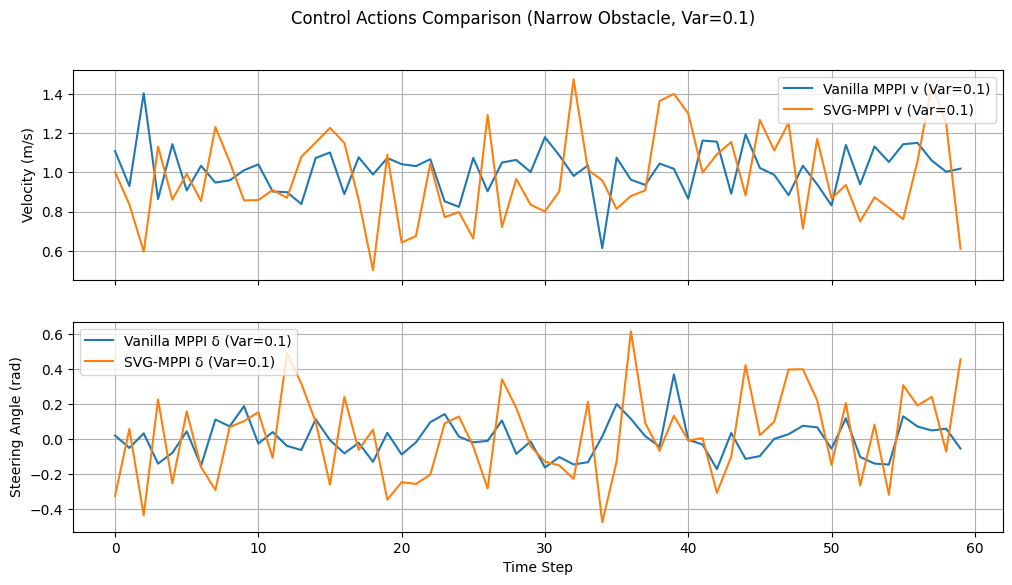

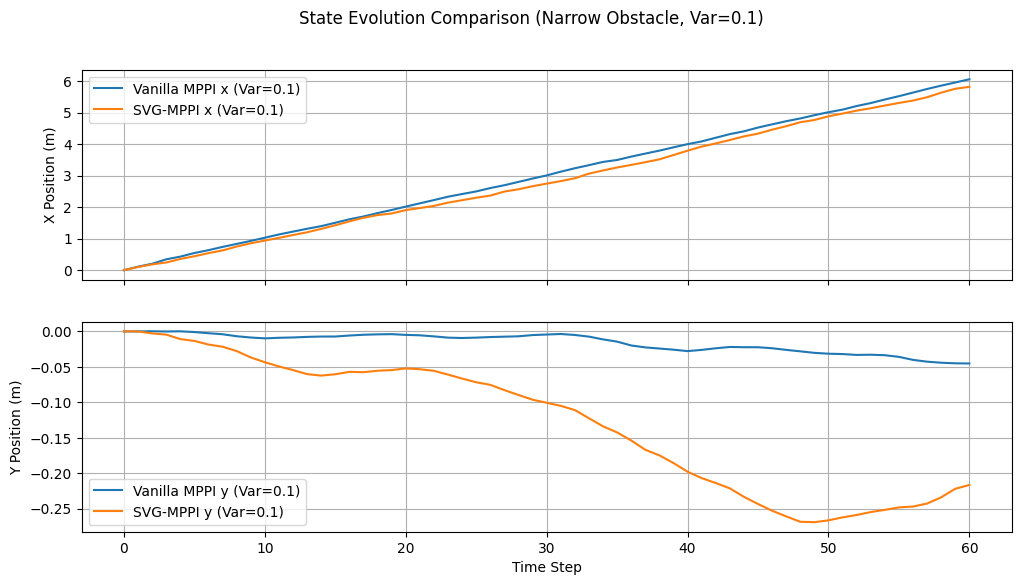

In [45]:
# Use the control sequences used above to extract state and control evolutions
vanilla_ctrl_best = u_nominal + np.random.normal(0, 0.1, T * 2)
svgd_ctrl_best = u_nominal_guide + np.random.normal(0, 0.1, T * 2)

# Extract states and controls
vanilla_states, vanilla_controls = extract_states_and_controls(vanilla_ctrl_best, start_state)
svgd_states, svgd_controls = extract_states_and_controls(svgd_ctrl_best, start_state)

# Plot control actions for narrow obstacle scenario
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_controls[:, 0], label='Vanilla MPPI v (Var=0.1)')
axs[0].plot(svgd_controls[:, 0], label='SVG-MPPI v (Var=0.1)')
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_controls[:, 1], label='Vanilla MPPI δ (Var=0.1)')
axs[1].plot(svgd_controls[:, 1], label='SVG-MPPI δ (Var=0.1)')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Steering Angle (rad)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Control Actions Comparison (Narrow Obstacle, Var=0.1)")
plt.show()

# Plot state evolution for narrow obstacle scenario
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(vanilla_states[:, 0], label='Vanilla MPPI x (Var=0.1)')
axs[0].plot(svgd_states[:, 0], label='SVG-MPPI x (Var=0.1)')
axs[0].set_ylabel("X Position (m)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(vanilla_states[:, 1], label='Vanilla MPPI y (Var=0.1)')
axs[1].plot(svgd_states[:, 1], label='SVG-MPPI y (Var=0.1)')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Y Position (m)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("State Evolution Comparison (Narrow Obstacle, Var=0.1)")
plt.show()


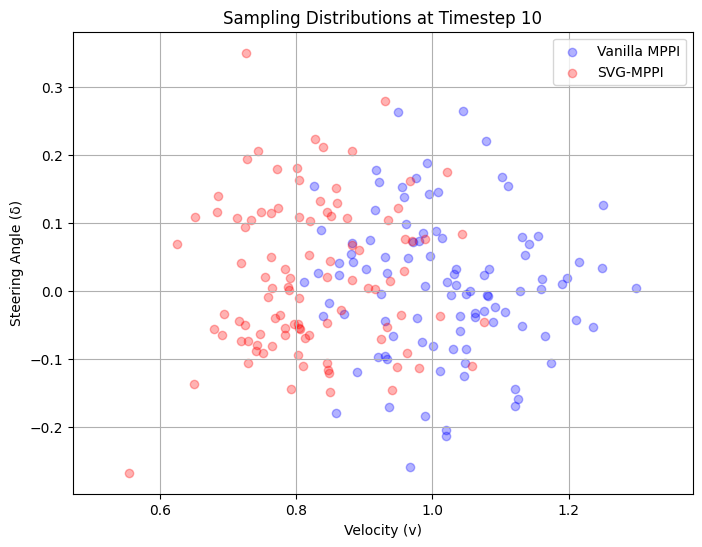

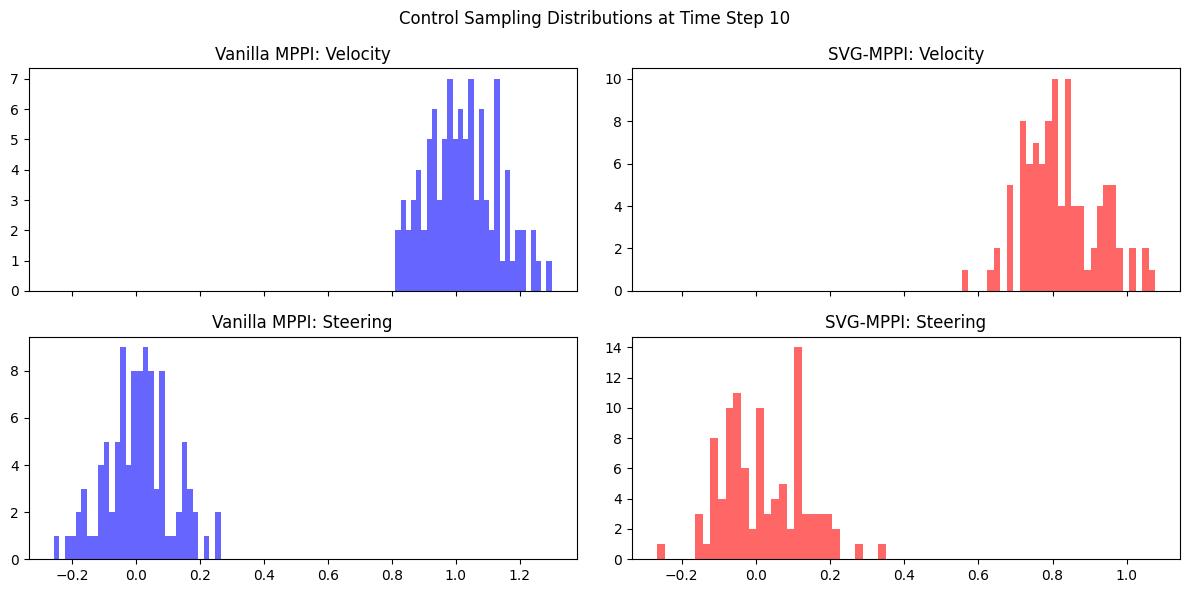

In [46]:
# Set time step to visualize control distribution (e.g., t=10)
t = 10

# Generate control samples at timestep t for both Vanilla and SVG-MPPI
vanilla_samples = np.array([
    (u_nominal + np.random.normal(0, 0.1, T * 2))[t*2:t*2+2]
    for _ in range(K)
])

svgd_samples = np.array([
    (u_nominal_guide + np.random.normal(0, 0.1, T * 2))[t*2:t*2+2]
    for _ in range(K)
])

# 2D scatter plot of (v, δ)
plt.figure(figsize=(8, 6))
plt.scatter(vanilla_samples[:, 0], vanilla_samples[:, 1], color='blue', alpha=0.3, label='Vanilla MPPI')
plt.scatter(svgd_samples[:, 0], svgd_samples[:, 1], color='red', alpha=0.3, label='SVG-MPPI')
plt.xlabel("Velocity (v)")
plt.ylabel("Steering Angle (δ)")
plt.title(f"Sampling Distributions at Timestep {t}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Histograms of individual dimensions
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex='col')

axs[0, 0].hist(vanilla_samples[:, 0], bins=30, color='blue', alpha=0.6)
axs[0, 0].set_title("Vanilla MPPI: Velocity")

axs[1, 0].hist(vanilla_samples[:, 1], bins=30, color='blue', alpha=0.6)
axs[1, 0].set_title("Vanilla MPPI: Steering")

axs[0, 1].hist(svgd_samples[:, 0], bins=30, color='red', alpha=0.6)
axs[0, 1].set_title("SVG-MPPI: Velocity")

axs[1, 1].hist(svgd_samples[:, 1], bins=30, color='red', alpha=0.6)
axs[1, 1].set_title("SVG-MPPI: Steering")

plt.suptitle(f"Control Sampling Distributions at Time Step {t}")
plt.tight_layout()
plt.show()


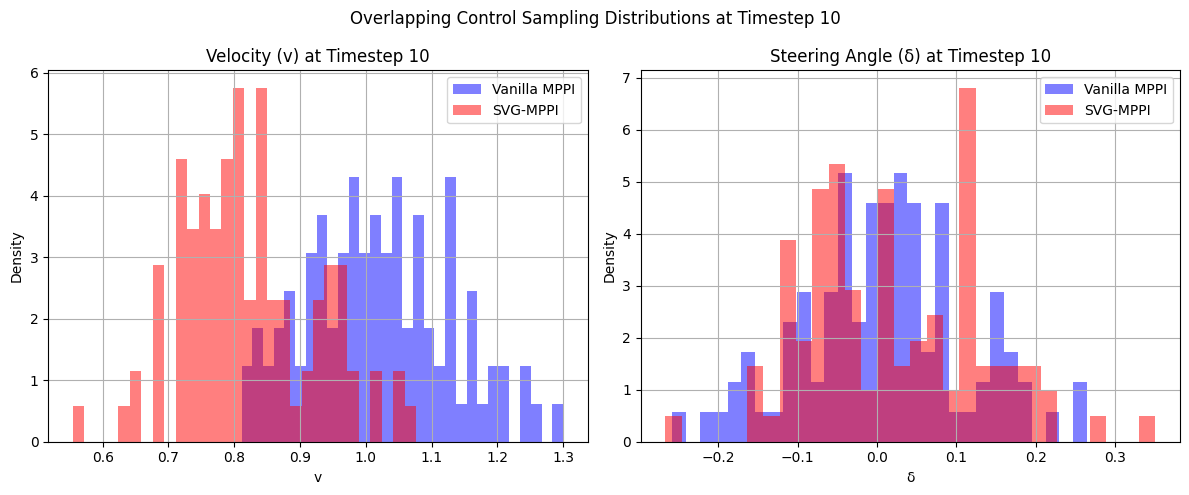

In [47]:
# Overlapping histograms for both methods at timestep t for v and δ

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Velocity
axs[0].hist(vanilla_samples[:, 0], bins=30, alpha=0.5, label='Vanilla MPPI', color='blue', density=True)
axs[0].hist(svgd_samples[:, 0], bins=30, alpha=0.5, label='SVG-MPPI', color='red', density=True)
axs[0].set_title(f"Velocity (v) at Timestep {t}")
axs[0].set_xlabel("v")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(True)

# Steering Angle
axs[1].hist(vanilla_samples[:, 1], bins=30, alpha=0.5, label='Vanilla MPPI', color='blue', density=True)
axs[1].hist(svgd_samples[:, 1], bins=30, alpha=0.5, label='SVG-MPPI', color='red', density=True)
axs[1].set_title(f"Steering Angle (δ) at Timestep {t}")
axs[1].set_xlabel("δ")
axs[1].set_ylabel("Density")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Overlapping Control Sampling Distributions at Timestep 10")
plt.tight_layout()
plt.show()


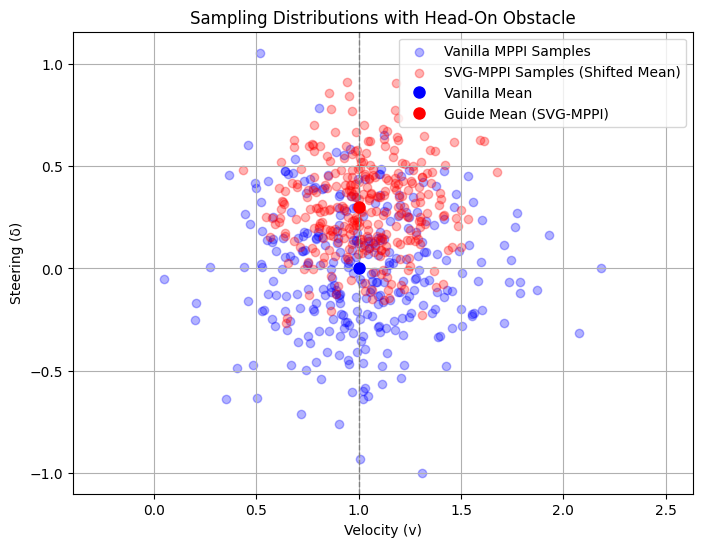

In [48]:
# Visualization of sampling Gaussians for a head-on obstacle scenario
# Assume head-on obstacle, so mode splitting should occur

# Set obstacle
obstacle_radius = 0.5
obstacle_center = np.array([3.0, 0.0])
goal_state_obstacle = np.array([6.0, 0.0])

# Create two Gaussian centers:
# - Vanilla MPPI: samples from nominal mean
# - SVG-MPPI: samples from guide particle shifted left or right
vanilla_mean = np.array([1.0, 0.0])  # Go straight
svgd_mean = np.array([1.0, 0.3])     # Slight right turn due to guide particle

# Sample from Gaussians
vanilla_samples = np.random.multivariate_normal(mean=vanilla_mean, cov=0.1*np.eye(2), size=300)
svgd_samples = np.random.multivariate_normal(mean=svgd_mean, cov=0.05*np.eye(2), size=300)

# Plot samples and annotate distributions
plt.figure(figsize=(8, 6))
plt.scatter(vanilla_samples[:, 0], vanilla_samples[:, 1], alpha=0.3, color='blue', label='Vanilla MPPI Samples')
plt.scatter(svgd_samples[:, 0], svgd_samples[:, 1], alpha=0.3, color='red', label='SVG-MPPI Samples (Shifted Mean)')
plt.axvline(1.0, color='gray', linestyle='--', linewidth=1)
plt.plot(vanilla_mean[0], vanilla_mean[1], 'bo', markersize=8, label='Vanilla Mean')
plt.plot(svgd_mean[0], svgd_mean[1], 'ro', markersize=8, label='Guide Mean (SVG-MPPI)')
plt.xlabel("Velocity (v)")
plt.ylabel("Steering (δ)")
plt.title("Sampling Distributions with Head-On Obstacle")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()


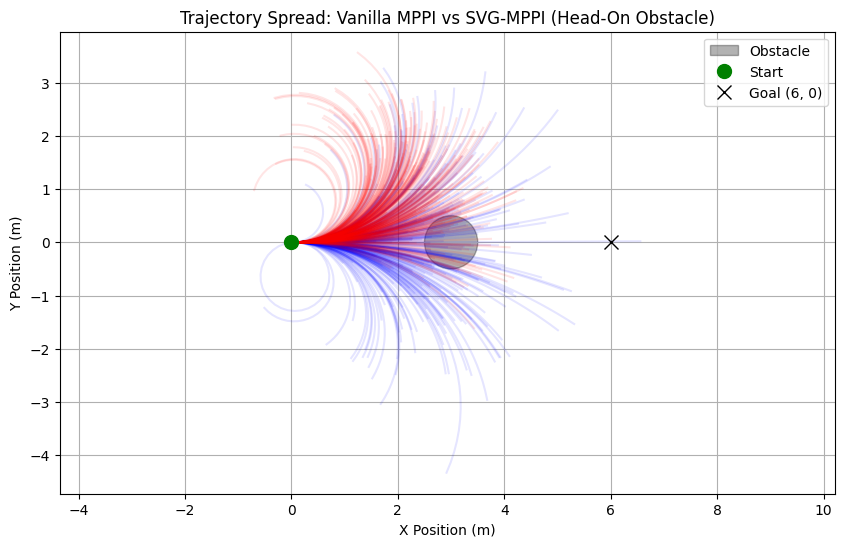

In [49]:
# Visualize the effect of MPPI vs SVG-MPPI in actual trajectory space (position)
# Use same initial state and simulate forward with sampled controls from shifted means

def simulate_position_distribution(samples, initial_state, dt=0.1, steps=30):
    trajs = []
    for ctrl_pair in samples:
        x, y, theta = initial_state
        traj = []
        for _ in range(steps):
            v, delta = ctrl_pair
            x += v * np.cos(theta) * dt
            y += v * np.sin(theta) * dt
            theta += (v / 1.0) * np.tan(delta) * dt
            traj.append((x, y))
        trajs.append(np.array(traj))
    return trajs

# Simulate both sets of trajectories
initial_state = np.array([0.0, 0.0, 0.0])
vanilla_trajs_pos = simulate_position_distribution(vanilla_samples, initial_state)
svgd_trajs_pos = simulate_position_distribution(svgd_samples, initial_state)

# Plot the resulting trajectories in position space
plt.figure(figsize=(10, 6))

# Vanilla
for traj in vanilla_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)
# SVG-MPPI
for traj in svgd_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)

# Plot obstacle and goal
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)
plt.plot(initial_state[0], initial_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_obstacle[0], goal_state_obstacle[1], 'kx', markersize=10, label='Goal (6, 0)')

plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Trajectory Spread: Vanilla MPPI vs SVG-MPPI (Head-On Obstacle)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


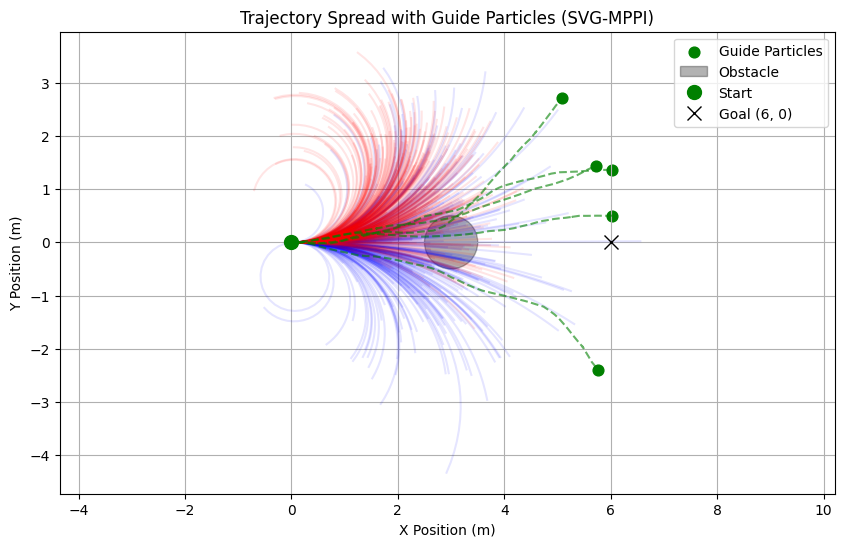

In [64]:
# Simulate and overlay guide particles in trajectory space

# Reuse guide particles from earlier (based on the u_nominal_guide logic)
guide_controls = []
guide_trajectories = []
guide_endpoints = []

for _ in range(5):
    ctrl = u_nominal + np.random.normal(0, 0.48, T * 2)
    guide_controls.append(ctrl)
    traj = simulate_trajectory(start_state, ctrl)
    guide_trajectories.append(traj)
    guide_endpoints.append(traj[-1])

# Plot again with guide particle trajectories
plt.figure(figsize=(10, 6))

# Vanilla MPPI trajectories
for traj in vanilla_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)

# SVG-MPPI trajectories
for traj in svgd_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)

# Guide particle trajectories (green dashed)
for traj in guide_trajectories:
    plt.plot(traj[:, 0], traj[:, 1], color='green', linestyle='--', alpha=0.6)

# Guide particle final positions
plt.scatter([pt[0] for pt in guide_endpoints], [pt[1] for pt in guide_endpoints],
            color='green', s=60, label='Guide Particles')

# Start, Goal, and Obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)
plt.plot(initial_state[0], initial_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_obstacle[0], goal_state_obstacle[1], 'kx', markersize=10, label='Goal (6, 0)')

plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Trajectory Spread with Guide Particles (SVG-MPPI)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


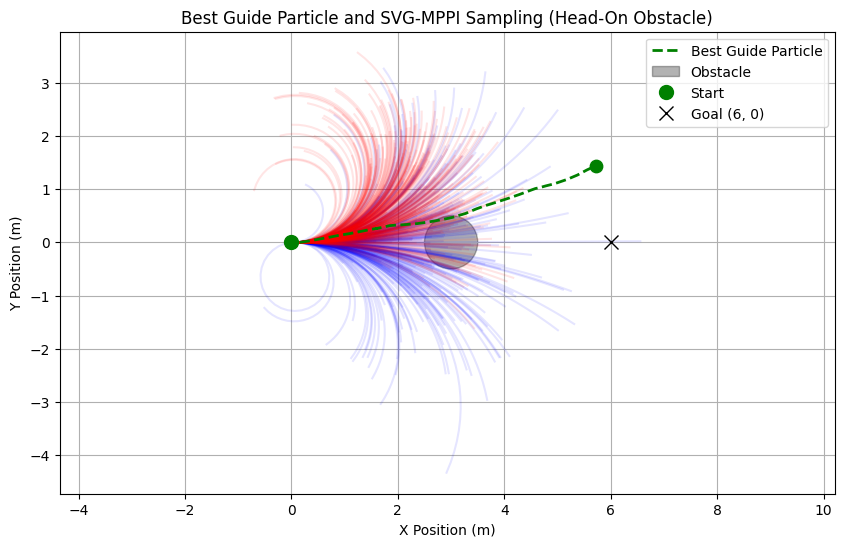

In [65]:
# Only keep and plot the best guide particle used for SVG-MPPI sampling
best_guide_traj = guide_trajectories[best_guide_idx]
best_guide_final = guide_endpoints[best_guide_idx]

# Plot again with only the best guide particle
plt.figure(figsize=(10, 6))

# Vanilla MPPI trajectories
for traj in vanilla_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.1)

# SVG-MPPI trajectories
for traj in svgd_trajs_pos:
    plt.plot(traj[:, 0], traj[:, 1], color='red', alpha=0.1)

# Best guide particle trajectory
plt.plot(best_guide_traj[:, 0], best_guide_traj[:, 1], color='green', linestyle='--', linewidth=2, label='Best Guide Particle')
plt.scatter(best_guide_final[0], best_guide_final[1], color='green', s=80)

# Obstacle
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
plt.gca().add_patch(circle)

# Start and goal
plt.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
plt.plot(goal_state_obstacle[0], goal_state_obstacle[1], 'kx', markersize=10, label='Goal (6, 0)')

plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Best Guide Particle and SVG-MPPI Sampling (Head-On Obstacle)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


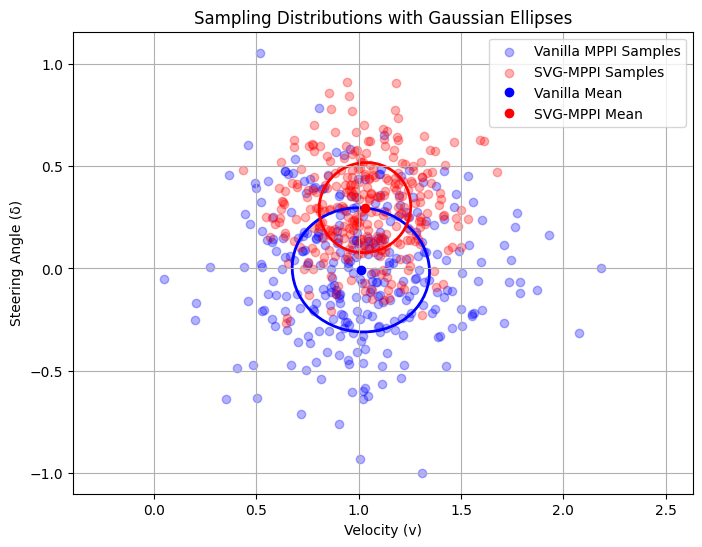

In [66]:
import matplotlib.patches as patches

# Plot SVG-MPPI and Vanilla MPPI samples with Gaussian ellipses at t=0 (initial sampling)
# Use the same vanilla_samples and svgd_samples arrays

# Fit Gaussian ellipses to the two distributions
def plot_cov_ellipse(mean, cov, ax, n_std=1.0, facecolor='none', edgecolor='k', **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = patches.Ellipse(xy=mean, width=width, height=height,
                              angle=angle, facecolor=facecolor,
                              edgecolor=edgecolor, lw=2, **kwargs)
    ax.add_patch(ellipse)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(vanilla_samples[:, 0], vanilla_samples[:, 1], color='blue', alpha=0.3, label='Vanilla MPPI Samples')
ax.scatter(svgd_samples[:, 0], svgd_samples[:, 1], color='red', alpha=0.3, label='SVG-MPPI Samples')

# Compute mean and cov
vanilla_mean = np.mean(vanilla_samples, axis=0)
vanilla_cov = np.cov(vanilla_samples.T)

svgd_mean = np.mean(svgd_samples, axis=0)
svgd_cov = np.cov(svgd_samples.T)

# Plot 1-sigma ellipses
plot_cov_ellipse(vanilla_mean, vanilla_cov, ax, n_std=1.0, edgecolor='blue')
plot_cov_ellipse(svgd_mean, svgd_cov, ax, n_std=1.0, edgecolor='red')

# Labels
ax.plot(vanilla_mean[0], vanilla_mean[1], 'bo', label='Vanilla Mean')
ax.plot(svgd_mean[0], svgd_mean[1], 'ro', label='SVG-MPPI Mean')
ax.set_xlabel("Velocity (v)")
ax.set_ylabel("Steering Angle (δ)")
ax.set_title("Sampling Distributions with Gaussian Ellipses")
ax.legend()
ax.grid(True)
ax.axis('equal')
plt.show()


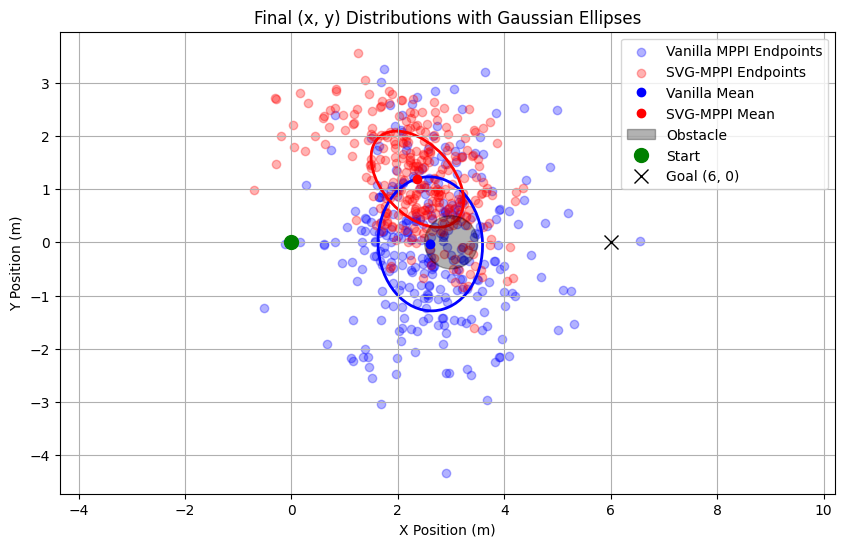

In [67]:
# For visualization in (x, y) position space, compute endpoint distributions of trajectories

# Collect final (x, y) positions for Vanilla and SVG-MPPI trajectories
vanilla_xy_end = np.array([traj[-1] for traj in vanilla_trajs_pos])
svgd_xy_end = np.array([traj[-1] for traj in svgd_trajs_pos])

# Plot in (x, y) space with Gaussian ellipses
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of endpoints
ax.scatter(vanilla_xy_end[:, 0], vanilla_xy_end[:, 1], color='blue', alpha=0.3, label='Vanilla MPPI Endpoints')
ax.scatter(svgd_xy_end[:, 0], svgd_xy_end[:, 1], color='red', alpha=0.3, label='SVG-MPPI Endpoints')

# Compute and plot Gaussian ellipses for endpoint distributions
vanilla_xy_mean = np.mean(vanilla_xy_end, axis=0)
vanilla_xy_cov = np.cov(vanilla_xy_end.T)

svgd_xy_mean = np.mean(svgd_xy_end, axis=0)
svgd_xy_cov = np.cov(svgd_xy_end.T)

plot_cov_ellipse(vanilla_xy_mean, vanilla_xy_cov, ax, n_std=1.0, edgecolor='blue')
plot_cov_ellipse(svgd_xy_mean, svgd_xy_cov, ax, n_std=1.0, edgecolor='red')

# Mark means
ax.plot(vanilla_xy_mean[0], vanilla_xy_mean[1], 'bo', label='Vanilla Mean')
ax.plot(svgd_xy_mean[0], svgd_xy_mean[1], 'ro', label='SVG-MPPI Mean')

# Obstacle, start, and goal
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
ax.add_patch(circle)
ax.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
ax.plot(goal_state_obstacle[0], goal_state_obstacle[1], 'kx', markersize=10, label='Goal (6, 0)')

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_title("Final (x, y) Distributions with Gaussian Ellipses")
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.show()


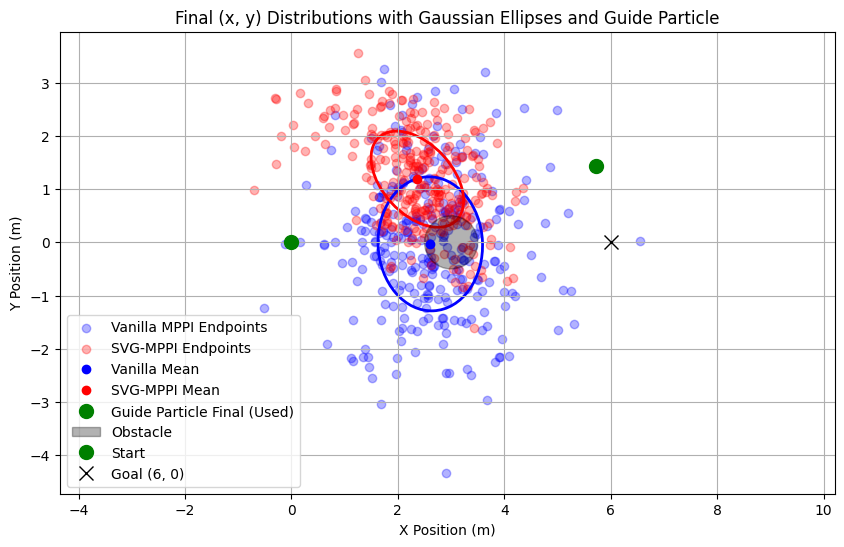

In [68]:
# Plot again with guide particle endpoint added to (x, y) Gaussian visualization

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of endpoints
ax.scatter(vanilla_xy_end[:, 0], vanilla_xy_end[:, 1], color='blue', alpha=0.3, label='Vanilla MPPI Endpoints')
ax.scatter(svgd_xy_end[:, 0], svgd_xy_end[:, 1], color='red', alpha=0.3, label='SVG-MPPI Endpoints')

# Gaussian ellipses for each distribution
plot_cov_ellipse(vanilla_xy_mean, vanilla_xy_cov, ax, n_std=1.0, edgecolor='blue')
plot_cov_ellipse(svgd_xy_mean, svgd_xy_cov, ax, n_std=1.0, edgecolor='red')

# Mean points
ax.plot(vanilla_xy_mean[0], vanilla_xy_mean[1], 'bo', label='Vanilla Mean')
ax.plot(svgd_xy_mean[0], svgd_xy_mean[1], 'ro', label='SVG-MPPI Mean')

# Guide particle final state
ax.plot(best_guide_final[0], best_guide_final[1], 'go', markersize=10, label='Guide Particle Final (Used)')

# Obstacle, start, and goal
circle = plt.Circle(obstacle_center, obstacle_radius, color='black', alpha=0.3, label='Obstacle')
ax.add_patch(circle)
ax.plot(start_state[0], start_state[1], 'go', markersize=10, label='Start')
ax.plot(goal_state_obstacle[0], goal_state_obstacle[1], 'kx', markersize=10, label='Goal (6, 0)')

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_title("Final (x, y) Distributions with Gaussian Ellipses and Guide Particle")
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.show()
